In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from plotnine import ggplot, aes, geom_point, geom_line
import pyreadr

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data processing

In [3]:
# Read data
data = pyreadr.read_r('song_data.rds') 
data = data[None]

In [4]:
data['release_year'] = pd.to_datetime(data['release_date']).dt.year
# print(data['release_year'])
data_genres_composition = data.where(data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]))
data_genres_composition = data_genres_composition.dropna(how='all')
# print(data_genres_composition)
data_genres_composition = data_genres_composition.groupby(['release_year', 'tag']).size().unstack().reset_index()
display(data_genres_composition)
visu_data = data_genres_composition.copy()
data_genres_composition['sum'] = data_genres_composition['folk'] + data_genres_composition['hiphop'] + data_genres_composition['pop'] + data_genres_composition['rock']
data_genres_composition['folk_prop'] = data_genres_composition['folk'] / data_genres_composition['sum']
data_genres_composition['hiphop_prop'] = data_genres_composition['hiphop'] / data_genres_composition['sum']
data_genres_composition['pop_prop'] = data_genres_composition['pop'] / data_genres_composition['sum']
data_genres_composition['rock_prop'] = data_genres_composition['rock'] / data_genres_composition['sum']
display(data_genres_composition)

tag,release_year,folk,hiphop,pop,rock
0,2009.0,177,54,963,204
1,2010.0,140,137,1079,227
2,2011.0,279,113,1023,415
3,2012.0,289,271,1251,473
4,2013.0,438,314,1660,564
5,2014.0,802,804,2432,1211
6,2015.0,1297,918,2882,1687
7,2016.0,1072,849,3908,1447
8,2017.0,1775,2365,6497,2203
9,2018.0,1902,3636,9687,1940


tag,release_year,folk,hiphop,pop,rock,sum,folk_prop,hiphop_prop,pop_prop,rock_prop
0,2009.0,177,54,963,204,1398,0.126609,0.038627,0.688841,0.145923
1,2010.0,140,137,1079,227,1583,0.088440,0.086545,0.681617,0.143399
2,2011.0,279,113,1023,415,1830,0.152459,0.061749,0.559016,0.226776
3,2012.0,289,271,1251,473,2284,0.126532,0.118651,0.547723,0.207093
4,2013.0,438,314,1660,564,2976,0.147177,0.105511,0.557796,0.189516
5,2014.0,802,804,2432,1211,5249,0.152791,0.153172,0.463326,0.230711
6,2015.0,1297,918,2882,1687,6784,0.191185,0.135318,0.424823,0.248673
7,2016.0,1072,849,3908,1447,7276,0.147334,0.116685,0.537108,0.198873
8,2017.0,1775,2365,6497,2203,12840,0.138240,0.184190,0.505997,0.171573
9,2018.0,1902,3636,9687,1940,17165,0.110807,0.211826,0.564346,0.113021


## Data visualization

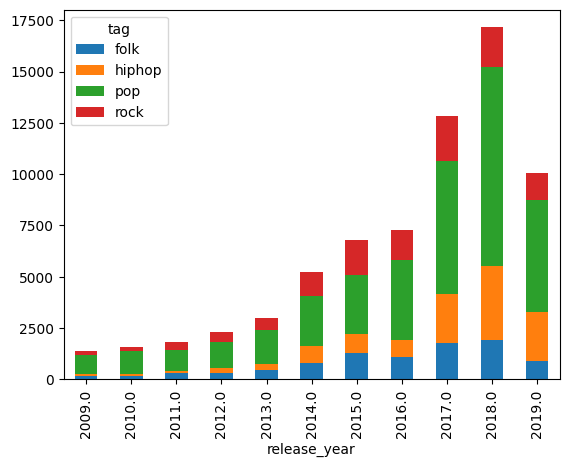

In [5]:
ax = visu_data.plot.bar(x='release_year',stacked=True)
plt.show()

# Machine learning

In [6]:
# ml_data = data[data['release_year'] == 2009].nlargest(50, 'listen_times')
ml_data = data[data['release_year'] == 2009]

# Split data into train and test sets
ml_train, ml_test = train_test_split(ml_data, test_size=0.2, random_state=210016, shuffle=True)

# Select features for training and testing
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]

y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]

## Naive Bayes

In [7]:
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_train_prob = nb_model.predict_proba(ml_train.iloc[:, 1:])
print(np.mean(p_train == ml_train.iloc[:, 0]))
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print(np.mean(p_test == ml_test.iloc[:, 0]))
print(roc_auc_score(y_true, p_test_prob, multi_class='ovr'))

0.6082289803220036
0.6285714285714286
0.7539339972071808


## K-Nearest Neighbors

In [8]:
df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 41):
    print(k)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_model_prob = knn_model.predict_proba(ml_test.iloc[:, 1:])
    y_pred_lab = knn_model.predict(ml_test.iloc[:, 1:])
    acc = np.mean(y_pred_lab == ml_test.iloc[:, 0])
    auc = roc_auc_score(y_true, knn_model_prob, multi_class='ovr')
    # df_knn_auc = df_knn_auc.append({'k': k, 'acc': acc, 'auc': auc}, ignore_index=True)
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
df_knn_auc = df_knn_auc.sort_values(by='acc', ascending=False)
display(df_knn_auc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


,k,acc,auc
0,9,0.760714,0.812217
0,8,0.757143,0.806108
0,11,0.757143,0.805675
0,17,0.753571,0.798068
0,16,0.753571,0.800327
0,6,0.753571,0.783771
0,18,0.750000,0.796110
0,12,0.750000,0.810317
0,30,0.746429,0.797897
0,14,0.746429,0.801806


## Random Forest

In [9]:
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(20, 41):
    for max in range(20, 41):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_model_prob = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = np.mean(rf_model.predict(ml_test.iloc[:, 1:]) == ml_test.iloc[:, 0])
        auc = roc_auc_score(y_true, rf_model_prob, multi_class='ovr')
        # df_rf_auc = df_rf_auc.append({'n': n, 'max': max, 'acc': acc, 'auc': auc}, ignore_index=True)
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max, 'acc': acc, 'auc': auc}])])
        # print('depth :',max)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(by='acc', ascending=False)
display(df_rf_auc)

n : 20
n : 21
n : 22
n : 23
n : 24
n : 25
n : 26
n : 27
n : 28
n : 29
n : 30
n : 31
n : 32
n : 33
n : 34
n : 35
n : 36
n : 37
n : 38
n : 39
n : 40


,n,max,acc,auc
0,33,20,0.778571,0.830165
0,30,32,0.771429,0.823081
0,30,38,0.771429,0.811341
0,39,20,0.771429,0.836842
0,39,26,0.767857,0.829601
0,33,38,0.767857,0.824676
0,34,35,0.767857,0.808773
0,32,22,0.767857,0.815056
0,31,35,0.767857,0.816747
0,30,37,0.767857,0.812782


## XGBoost

In [10]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 4}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
print('training')
for iter in range(1, 11):
    print('epoch',iter)
    param = best_param.copy()
    param['max_depth'] = np.random.randint(2, 6)
    param['eta'] = np.random.uniform(0.01, 0.3)
    seed_number=np.random.randint(10000)
    cv_result = xgb.cv(params=param, dtrain=train_matrix, num_boost_round=1000, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
    
nround = best_logloss_index
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)
test_pred = bst_model.predict(test_matrix)
test_prediction = pd.DataFrame(test_pred).apply(lambda x: np.argmax(x), axis=1)
print(np.mean(test_prediction.to_numpy() == ml_test_num.iloc[:, 0].to_numpy()))
print(roc_auc_score(y_true, test_pred, multi_class='ovr'))

training
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
0.7535714285714286
0.5165673443691609


# Prediction

In [11]:
data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'treatment_date'] = np.where(data_predict.loc[:,'release_date'] < pd.to_datetime('2017-06-24'), 0, 1)
data_predict.loc[:,'treatment_year'] = np.where(data_predict.loc[:,'release_year'] < 2017, 0, 1)

/tmp/ipykernel_4665/1694111673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/1694111673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/1694111673.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/tmp/ipykernel_4665/1694111673.py:4: SettingWithCopyWarning: 
A valu

## Naive Bayes

In [12]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(data_predict.iloc[:, 6:17])
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']

/tmp/ipykernel_4665/443113763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/443113763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/443113763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/44311376

## K-Nearest Neighbors

In [13]:
data_predict['knn_pred'] = knn_model.predict(data_predict.iloc[:, 6:17])
data_predict['knn_pred_acc'] = data_predict['knn_pred'] == data_predict['tag']
data_predict['knn_pred_bin'] = np.where(data_predict['knn_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['knn_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['knn_pred_bin']

/tmp/ipykernel_4665/134867769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/134867769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/134867769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/13486776

## Random Forest

In [14]:
data_predict['rf_pred'] = rf_model.predict(data_predict.iloc[:, 6:17])
data_predict['rf_pred_acc'] = data_predict['rf_pred'] == data_predict['tag']
data_predict['rf_pred_bin'] = np.where(data_predict['rf_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['rf_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['rf_pred_bin']

/tmp/ipykernel_4665/309029341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/309029341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/309029341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/30902934

## XGBoost

In [15]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(data_predict.iloc[:, 6:17]))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: np.argmax(x) + 1, axis=1)
data_predict['xgb_pred_acc'] = data_predict['xgb_pred'] == data_predict['tag']
data_predict['xgb_pred_bin'] = np.where(data_predict['xgb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['xgb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['xgb_pred_bin']

/tmp/ipykernel_4665/1823267812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/1823267812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/1823267812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4665/18232

In [16]:
# print(data_predict)
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_2009.pkl')

Index(['song_id', 'tag', 'release_date', 'release_month', 'release_year',
       'listen_times', 'chroma_stft_norm', 'rmse_norm',
       'spectral_centroid_norm', 'spectral_bandwidth_norm', 'rolloff_norm',
       'zero_crossing_rate_norm', 'mfcc1_norm', 'mfcc2_norm', 'mfcc3_norm',
       'mfcc4_norm', 'mfcc5_norm', 'mfcc6_norm', 'mfcc7_norm', 'mfcc8_norm',
       'mfcc9_norm', 'mfcc10_norm', 'mfcc11_norm', 'mfcc12_norm',
       'mfcc13_norm', 'mfcc14_norm', 'mfcc15_norm', 'mfcc16_norm',
       'mfcc17_norm', 'mfcc18_norm', 'mfcc19_norm', 'mfcc20_norm', 'tag_bin',
       'treatment_date', 'treatment_year', 'gnb_pred', 'gnb_pred_acc',
       'gnb_pred_bin', 'gnb_pred_bin_acc', 'knn_pred', 'knn_pred_acc',
       'knn_pred_bin', 'knn_pred_bin_acc', 'rf_pred', 'rf_pred_acc',
       'rf_pred_bin', 'rf_pred_bin_acc', 'xgb_pred', 'xgb_pred_acc',
       'xgb_pred_bin', 'xgb_pred_bin_acc'],
      dtype='object')


# Metrics

## Naive Bayes

In [17]:
gnb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear    = data_predict.copy()[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics)
print(gnb_metrics.columns)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(gnb_metrics)

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,0,0.612303,0.949928,0.351852,0.351852
1,2010,0,0.540745,0.890082,0.087591,0.196721
2,2011,0,0.468852,0.902732,0.088496,0.117647
3,2012,0,0.492995,0.863398,0.118081,0.304762
4,2013,0,0.484879,0.878696,0.105096,0.292035
5,2014,0,0.435321,0.830444,0.108209,0.334615
6,2015,0,0.427329,0.854805,0.144880,0.399399
7,2016,0,0.448048,0.866135,0.117786,0.307692
8,2017,1,0.457009,0.818925,0.124736,0.536364
9,2018,1,0.477833,0.791087,0.110286,0.533245


Index(['release_year', 'treatment_year', 'gnb_pred_acc', 'gnb_pred_bin_acc',
       'gnb_recall', 'gnb_precision'],
      dtype='object')


,release_year,treatment_year,metrics,values
0,2009,0,gnb_pred_acc,0.612303
1,2010,0,gnb_pred_acc,0.540745
2,2011,0,gnb_pred_acc,0.468852
3,2012,0,gnb_pred_acc,0.492995
4,2013,0,gnb_pred_acc,0.484879
5,2014,0,gnb_pred_acc,0.435321
6,2015,0,gnb_pred_acc,0.427329
7,2016,0,gnb_pred_acc,0.448048
8,2017,1,gnb_pred_acc,0.457009
9,2018,1,gnb_pred_acc,0.477833


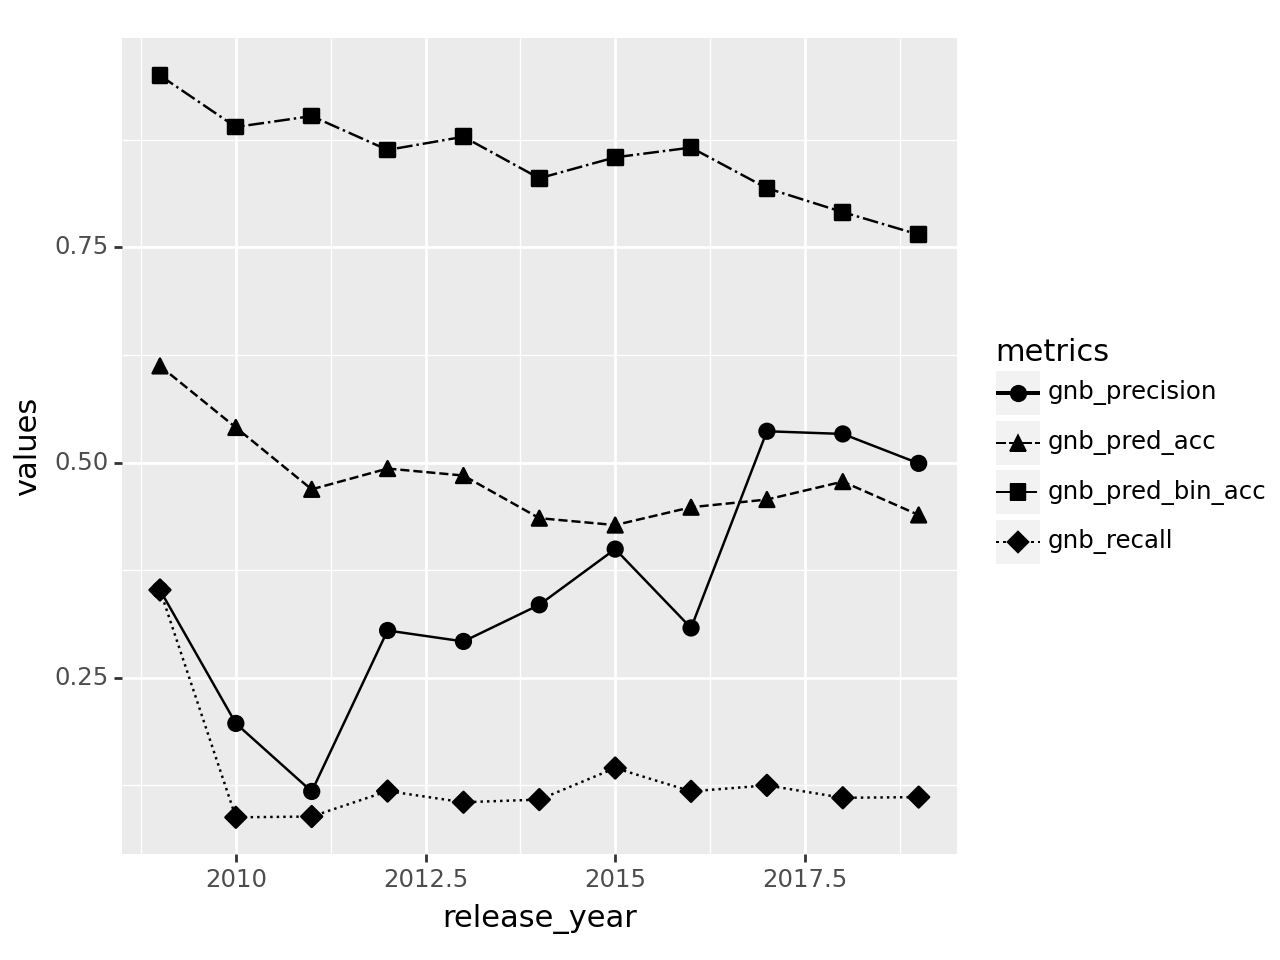

In [18]:
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_2009.pkl')

## K-Nearest Neighbors

,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,0,0.734621,0.961373,0.000000,1.0
1,2010,0,0.686671,0.913455,0.000000,NaN
2,2011,0,0.571038,0.938251,0.000000,NaN
3,2012,0,0.561734,0.881349,0.000000,NaN
4,2013,0,0.570901,0.894489,0.000000,NaN
5,2014,0,0.477043,0.846828,0.000000,NaN
6,2015,0,0.443396,0.864682,0.000000,NaN
7,2016,0,0.534360,0.883315,0.000000,NaN
8,2017,1,0.509735,0.815810,0.000000,NaN
9,2018,1,0.563647,0.788232,0.000275,NaN


,release_year,treatment_year,metrics,values
0,2009,0,knn_pred_acc,0.734621
1,2010,0,knn_pred_acc,0.686671
2,2011,0,knn_pred_acc,0.571038
3,2012,0,knn_pred_acc,0.561734
4,2013,0,knn_pred_acc,0.570901
5,2014,0,knn_pred_acc,0.477043
6,2015,0,knn_pred_acc,0.443396
7,2016,0,knn_pred_acc,0.534360
8,2017,1,knn_pred_acc,0.509735
9,2018,1,knn_pred_acc,0.563647


/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


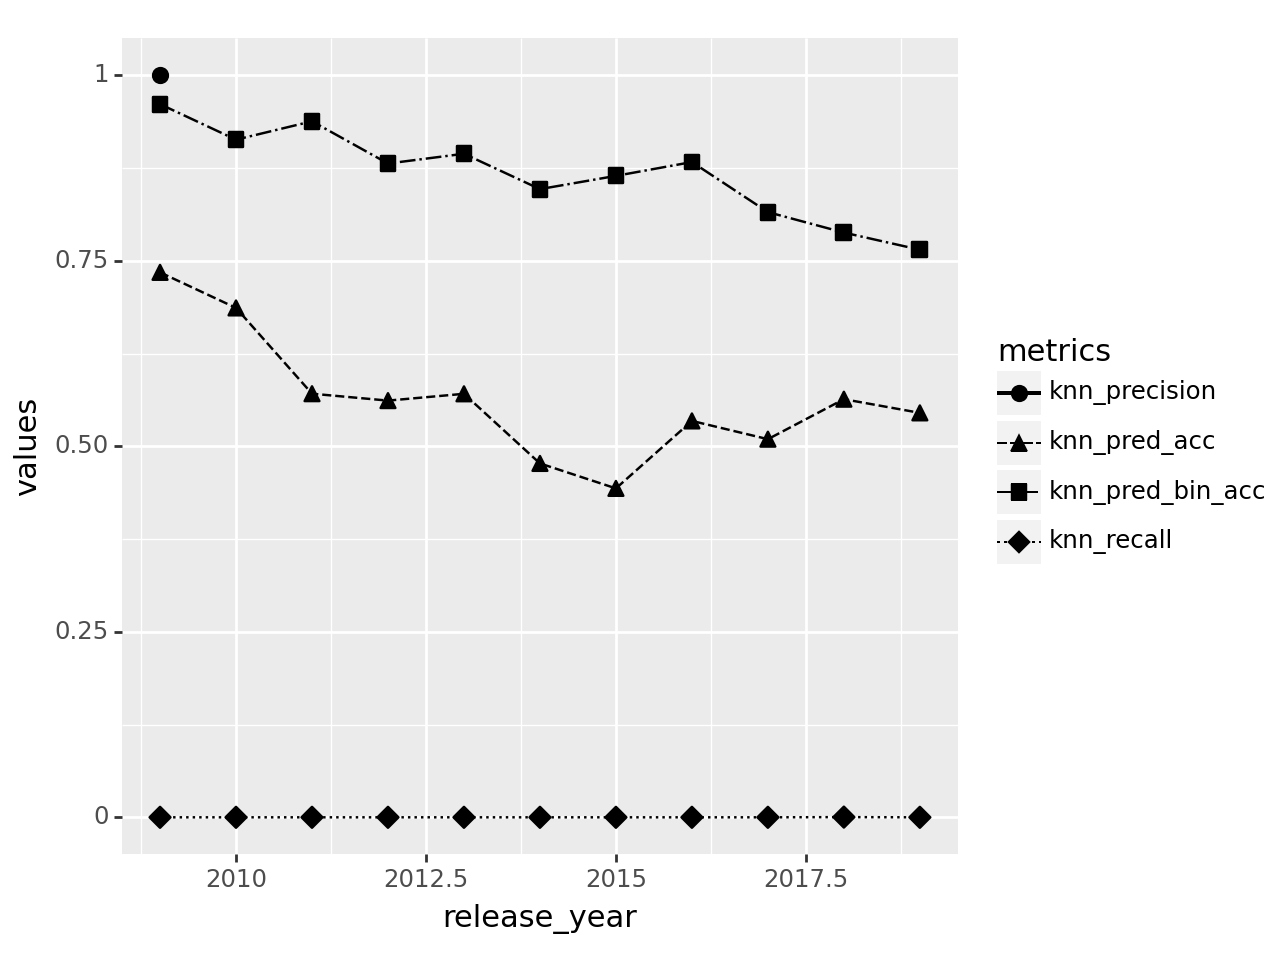

In [19]:
knn_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
knn_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
knn_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
knn_precision_tbyyear    = data_predict.copy()[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(knn_metrics)

knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_2009.pkl')

## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,0,0.949213,0.993562,0.833333,1.000000
1,2010,0,0.666456,0.914087,0.080292,0.523810
2,2011,0,0.574317,0.934426,0.053097,0.315789
3,2012,0,0.580998,0.882224,0.081181,0.523810
4,2013,0,0.562500,0.895833,0.101911,0.533333
5,2014,0,0.492665,0.853305,0.070896,0.712500
6,2015,0,0.459169,0.865419,0.080610,0.517483
7,2016,0,0.523502,0.880979,0.071849,0.438849
8,2017,1,0.518224,0.827103,0.094292,0.740864
9,2018,1,0.561025,0.802913,0.108636,0.735568


,release_year,treatment_year,metrics,values
0,2009,0,rf_pred_acc,0.949213
1,2010,0,rf_pred_acc,0.666456
2,2011,0,rf_pred_acc,0.574317
3,2012,0,rf_pred_acc,0.580998
4,2013,0,rf_pred_acc,0.562500
5,2014,0,rf_pred_acc,0.492665
6,2015,0,rf_pred_acc,0.459169
7,2016,0,rf_pred_acc,0.523502
8,2017,1,rf_pred_acc,0.518224
9,2018,1,rf_pred_acc,0.561025


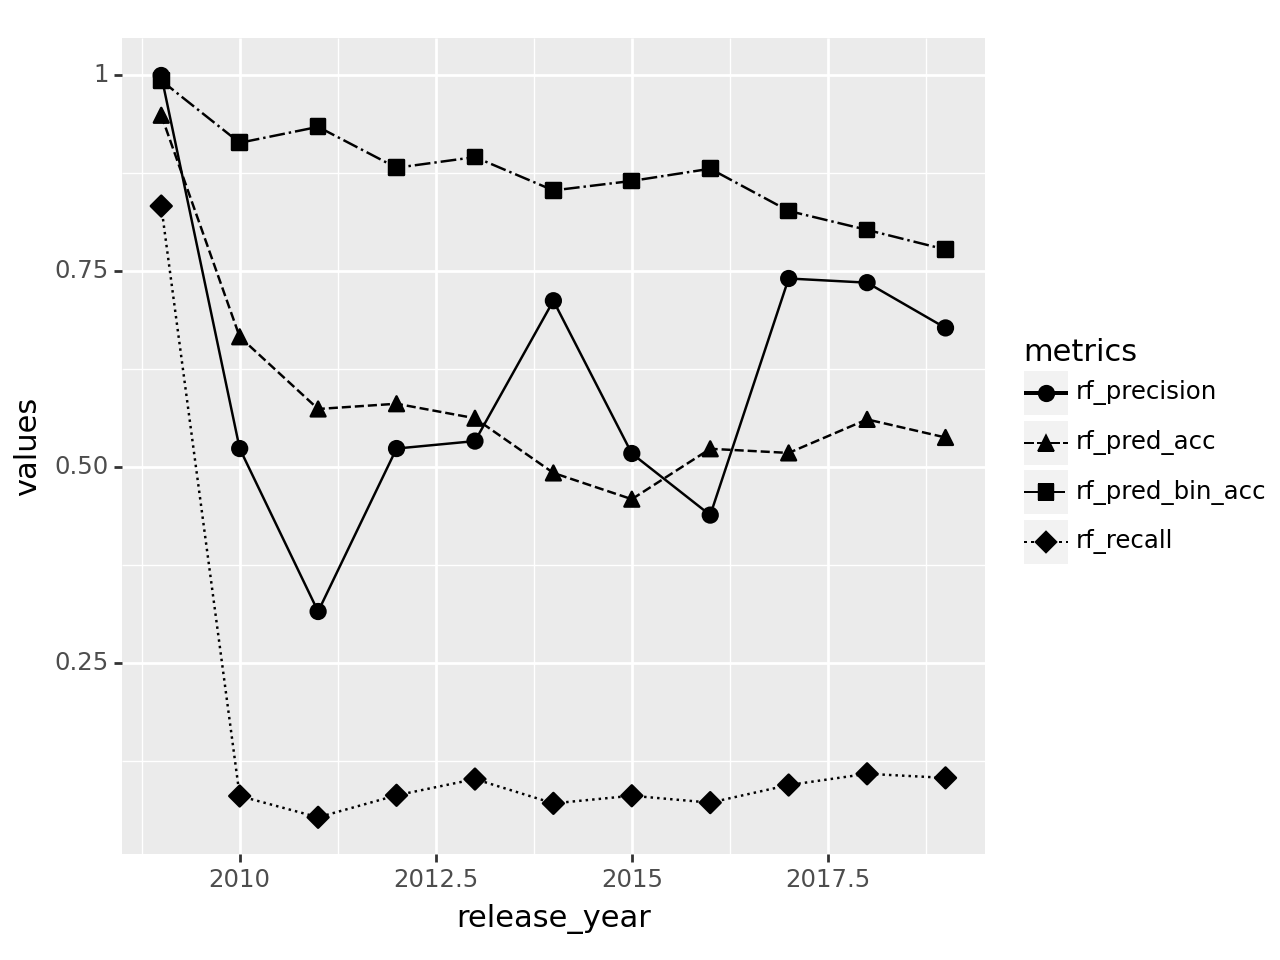

In [20]:
rf_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear    = data_predict.copy()[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(rf_metrics)

rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_2009.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,0,0.0,0.961373,0.0,NaN
1,2010,0,0.0,0.913455,0.0,NaN
2,2011,0,0.0,0.938251,0.0,NaN
3,2012,0,0.0,0.881349,0.0,NaN
4,2013,0,0.0,0.894489,0.0,NaN
5,2014,0,0.0,0.846828,0.0,NaN
6,2015,0,0.0,0.864682,0.0,NaN
7,2016,0,0.0,0.883315,0.0,NaN
8,2017,1,0.0,0.815810,0.0,NaN
9,2018,1,0.0,0.788174,0.0,NaN


,release_year,treatment_year,metrics,values
0,2009,0,xgb_pred_acc,0.000000
1,2010,0,xgb_pred_acc,0.000000
2,2011,0,xgb_pred_acc,0.000000
3,2012,0,xgb_pred_acc,0.000000
4,2013,0,xgb_pred_acc,0.000000
5,2014,0,xgb_pred_acc,0.000000
6,2015,0,xgb_pred_acc,0.000000
7,2016,0,xgb_pred_acc,0.000000
8,2017,1,xgb_pred_acc,0.000000
9,2018,1,xgb_pred_acc,0.000000


/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


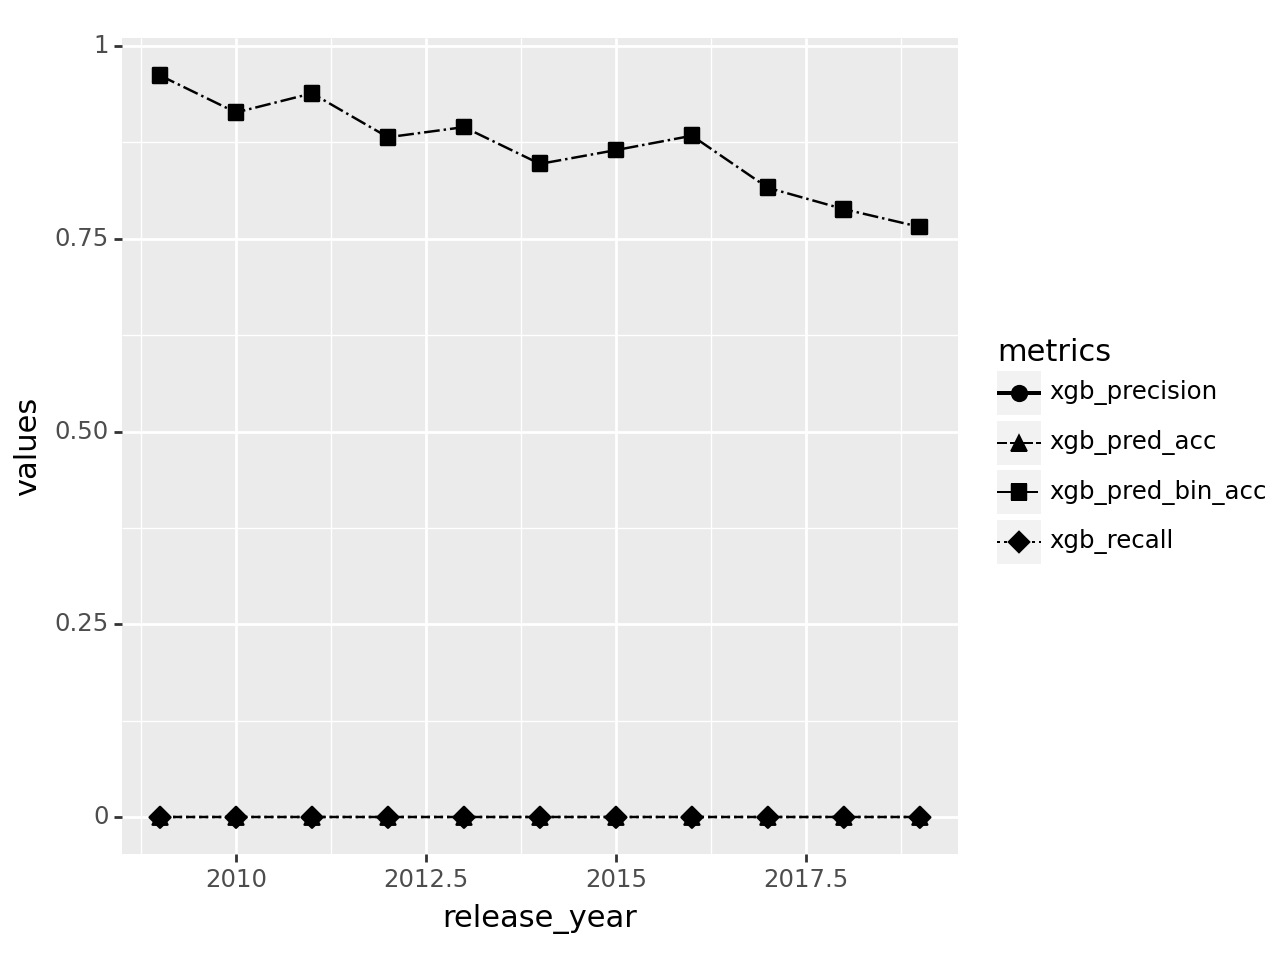

In [21]:
xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(xgb_metrics)

xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_2009.pkl')

## Total

,release_year,treatment_year,metrics,values
0,2009,0,classifiers_pred_acc,0.574034
1,2010,0,classifiers_pred_acc,0.473468
2,2011,0,classifiers_pred_acc,0.403552
3,2012,0,classifiers_pred_acc,0.408932
4,2013,0,classifiers_pred_acc,0.404570
5,2014,0,classifiers_pred_acc,0.351257
6,2015,0,classifiers_pred_acc,0.332473
7,2016,0,classifiers_pred_acc,0.376477
8,2017,1,classifiers_pred_acc,0.371242
9,2018,1,classifiers_pred_acc,0.400626


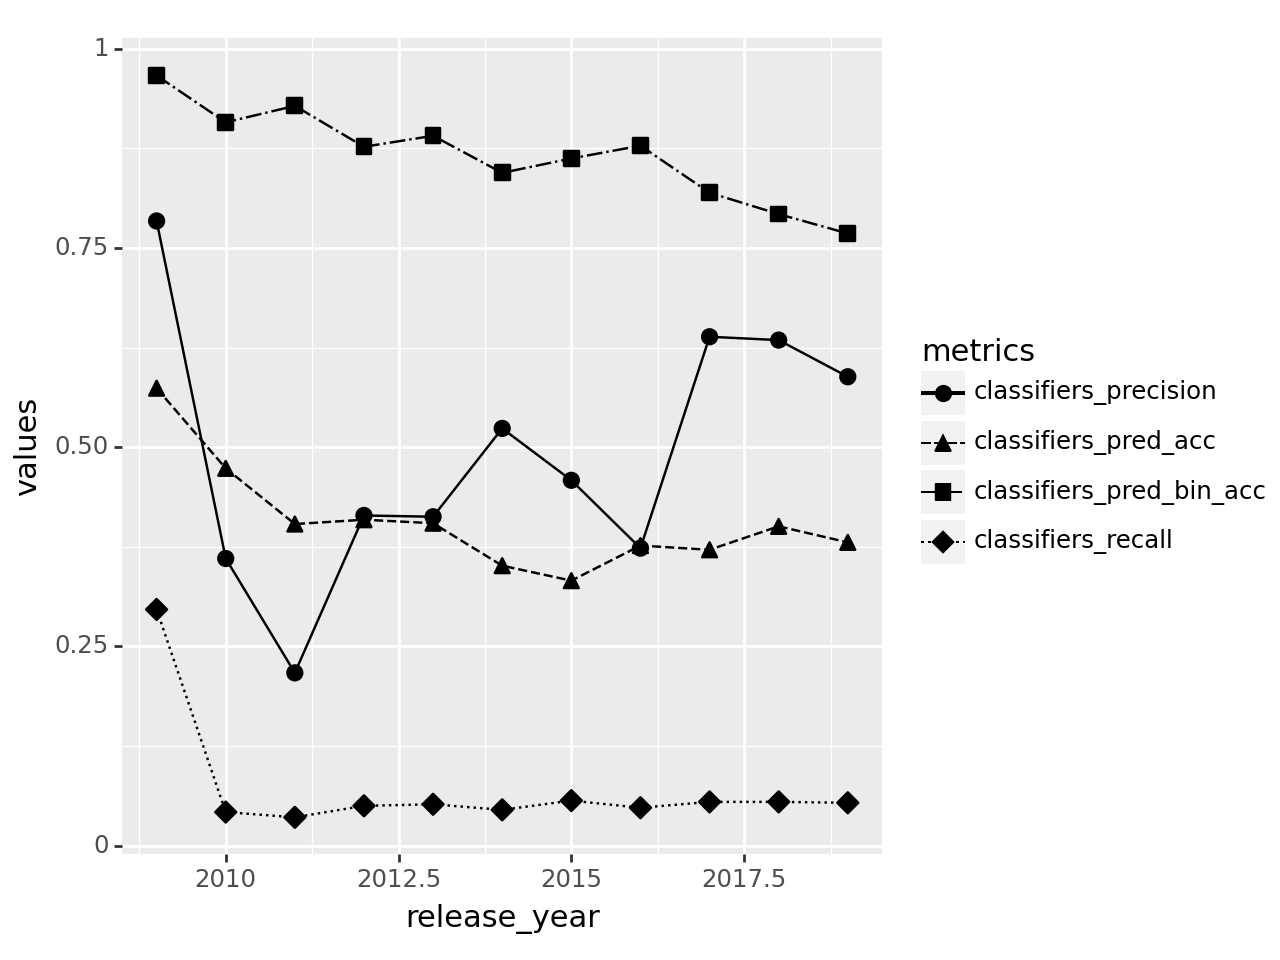

In [22]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_2009.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(average_plot)